## Dataset Links :

 - [256x256 pngs](https://www.kaggle.com/datasets/theoviel/rsna-breast-cancer-256-pngs)
 - [512x512 pngs](https://www.kaggle.com/datasets/theoviel/rsna-breast-cancer-512-pngs)
 - [768x768 pngs](https://www.kaggle.com/datasets/theoviel/rsna-breast-cancer-768-pngs)
 - [1024x1024 pngs](https://www.kaggle.com/datasets/theoviel/rsna-breast-cancer-1024-pngs)

**Changes :**
- Invert images with PhotometricInterpretation == "MONOCHROME1" 

## Initialization

In [1]:
!pip install -qU python-gdcm pydicom pylibjpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 113.3 MB/s eta 0:00:0000:01:01


In [2]:
import os
import cv2
import glob
import gdcm
import pydicom
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [3]:
train_images = glob.glob("/kaggle/input/rsna-breast-cancer-detection/train_images/*/*.dcm")

len(train_images)  # 54706

54706

In [18]:
# delete preprocessed_images folder if exists
if os.path.exists("/kaggle/working/output"):
    import shutil
    shutil.rmtree("/kaggle/working/output")

## Examples

  0%|          | 0/3 [00:00<?, ?it/s]

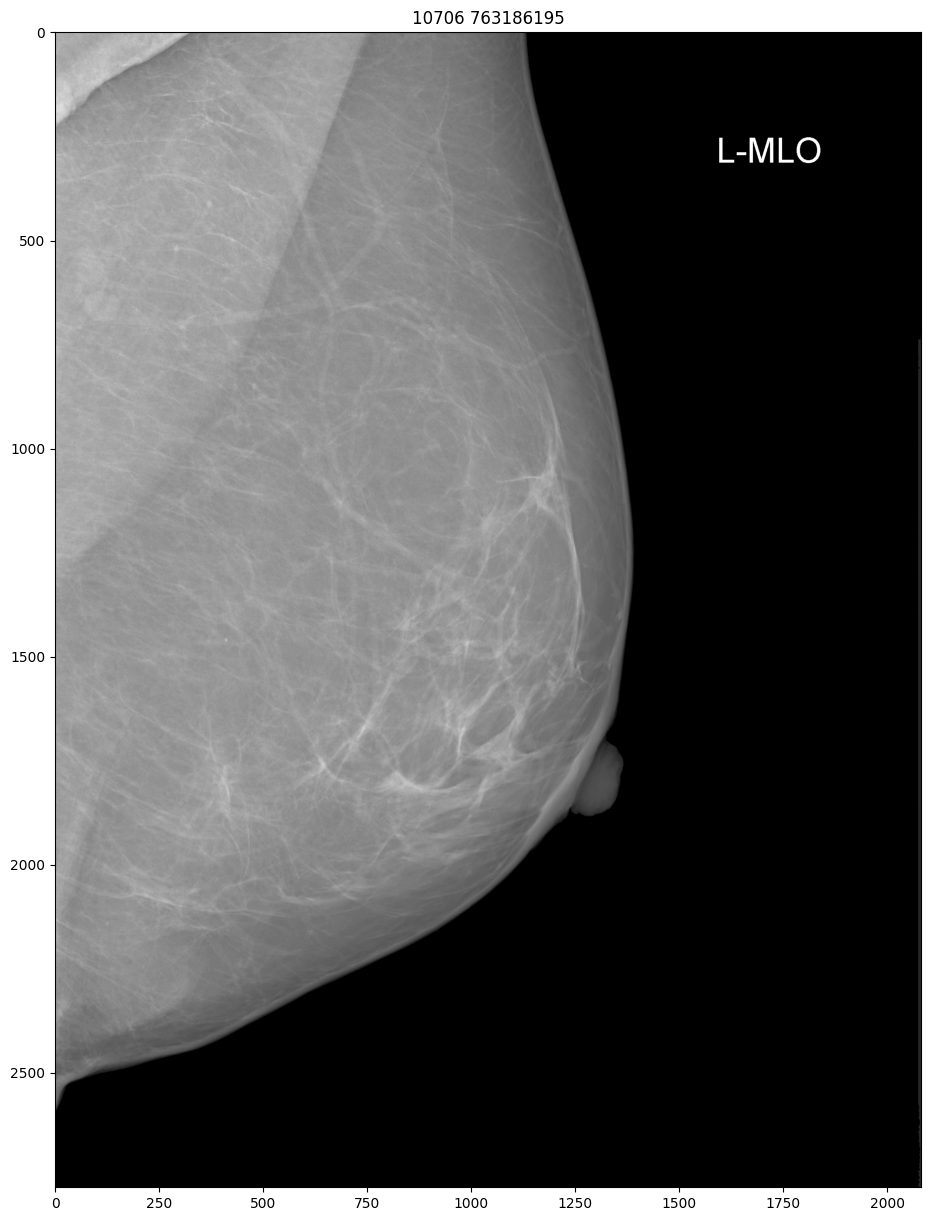

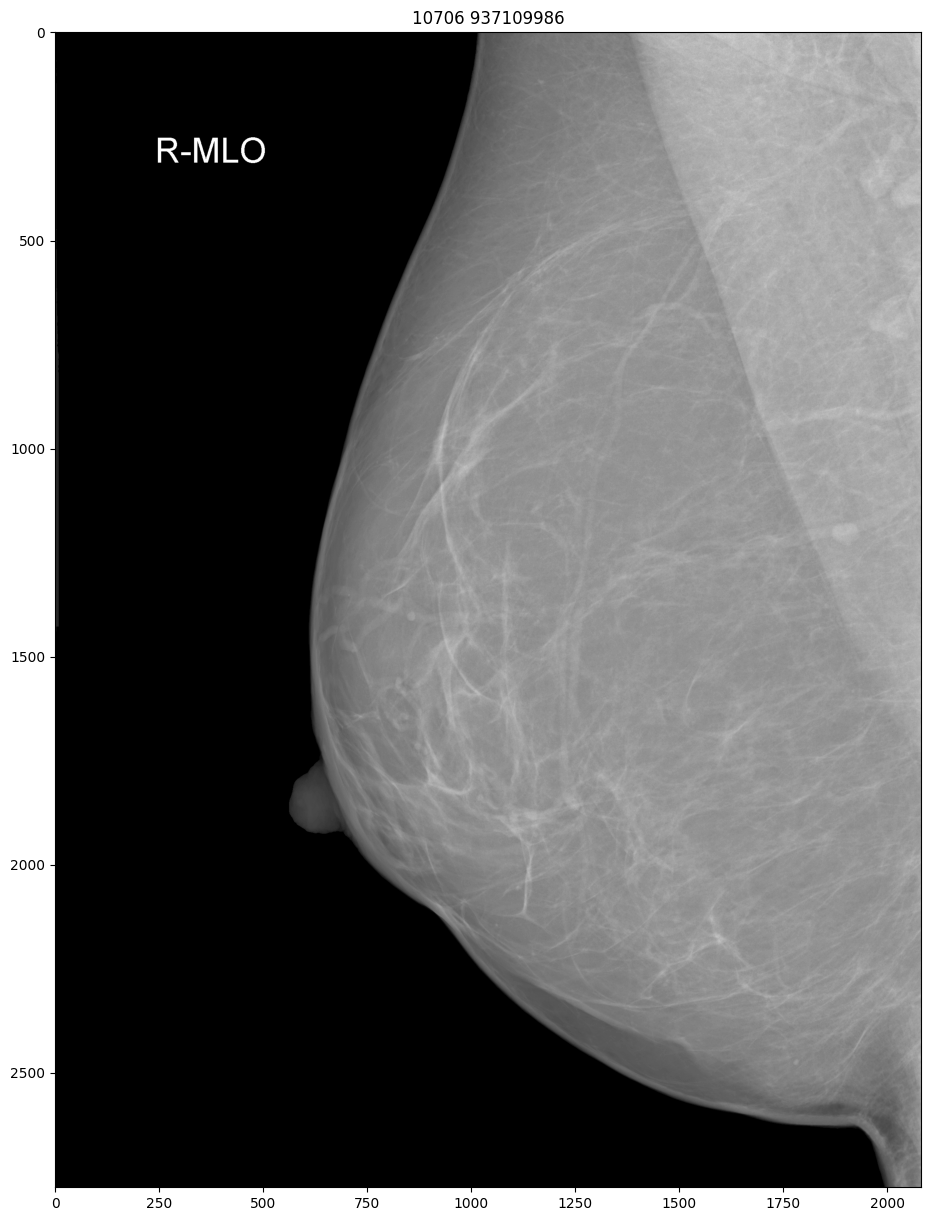

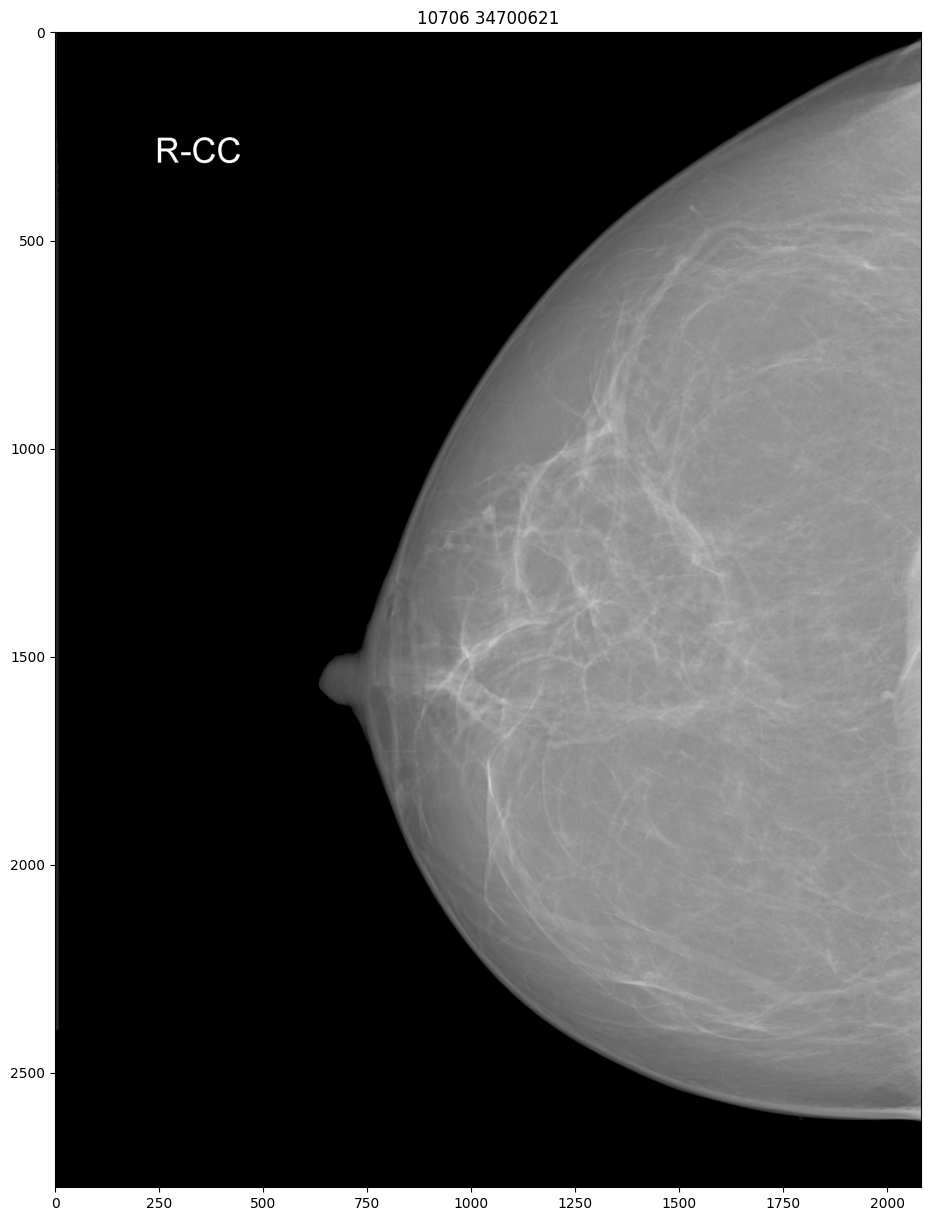

In [4]:
for f in tqdm(train_images[:3]):
    patient = f.split('/')[-2]
    image = f.split('/')[-1][:-4]

    dicom = pydicom.dcmread(f)
    img = dicom.pixel_array

    img = (img - img.min()) / (img.max() - img.min())

    if dicom.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img
        
    plt.figure(figsize=(15, 15))
    plt.imshow(img, cmap="gray")
    plt.title(f"{patient} {image}")
    plt.show()

## Save the processed data
**Images are quite big so resizing them is necessary.**
  - Use 256 to train your first models, or if you don't have a lot of compute
  - use 512 to have competitive models
  - Check if 768/1024 is better, if you have the compute power

**I advise using the `png` format because the jpg compression can be annoying during inference.**

In [4]:
SAVE_FOLDER = "/kaggle/working/"
SIZE = 512
EXTENSION = "png"

os.makedirs(SAVE_FOLDER, exist_ok=True)

In [7]:
# Configuration
conf = {
    'ROOT_DIR': '/kaggle/input/rsna-breast-cancer-detection',
    'SAVE_DIR': '/kaggle/working/'
}
# Create label-specific directories
os.makedirs(os.path.join(conf['SAVE_DIR'], '0'), exist_ok=True) # For Non-Cancer
os.makedirs(os.path.join(conf['SAVE_DIR'], '1'), exist_ok=True) # For Cancer

df = pd.read_csv(f"{conf['ROOT_DIR']}/train.csv")
df['path'] = df.apply(lambda x: f"{conf['ROOT_DIR']}/train_images/{x.patient_id}/{x.image_id}.dcm", axis=1)

In [10]:
def process(f, label, size=512, save_folder="", extension="png"):
    patient = f.split('/')[-2]
    image = f.split('/')[-1][:-4]

    dicom = pydicom.dcmread(f)
    img = dicom.pixel_array

    img = (img - img.min()) / (img.max() - img.min())

    if dicom.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img

    img = cv2.resize(img, (size, size))

    # Construct the save path with the class folder
    # e.g., save_folder/1/patient_image.png
    final_save_path = os.path.join(save_folder, str(label), f"{patient}_{image}.{extension}")
    
    cv2.imwrite(final_save_path, (img * 255).astype(np.uint8))

# You need a dataframe (like 'df' from your previous code) that has both 'path' and 'cancer' columns
# We iterate through the dataframe rows to get both the file path and the label
_ = Parallel(n_jobs=4)(
    delayed(process)(row.path, row.cancer, size=SIZE, save_folder=SAVE_FOLDER, extension=EXTENSION)
    for _, row in tqdm(df.iterrows(), total=len(df))
)

  0%|          | 0/54706 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
_ = Parallel(n_jobs=4)(
    delayed(process)(uid, size=SIZE, save_folder=SAVE_FOLDER, extension=EXTENSION)
    for uid in tqdm(train_images[:])
)

  0%|          | 0/54706 [00:00<?, ?it/s]

KeyboardInterrupt: 

Done !